<a href="https://www.kaggle.com/code/gregoryoliveira/brazil-weather-change-part-ii-data-analysis?scriptVersionId=100679363" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 1. Introduction

This notebook is part of [Applied Data Science with Python Specialization](https://www.coursera.org/specializations/data-science-python), especially the 2nd course [Applied Plotting, Charting & Data Representation in Python](https://www.coursera.org/learn/python-plotting?specialization=data-science-python).

"This assignment requires that you to find at least two datasets on the web which are related, and that you visualize these datasets to answer a question with the broad topic of weather phenomena (see below) for the region of Juiz de Fora, Minas Gerais, Brazil, or Brazil more broadly."

I choose to create a notebook that use [INMET](https://portal.inmet.gov.br/dadoshistoricos) (National Institute of Meteorology - Instituto Nacional de Meteorologia) to compare some measures between brazilian cities. This notebook was first built with Kaggle dataset [Brazil Weather, Automatic Stations (2000-2021)](https://www.kaggle.com/datasets/saraivaufc/automatic-weather-stations-brazil). However, considering that I want 2021 data updated, I code [the first part](https://www.kaggle.com/code/gregoryoliveira/brazil-weather-change-part-i-data-collection) to collect the data and summarize. The data is also avaiable as [Brazil Weather Information by INMET](https://www.kaggle.com/datasets/gregoryoliveira/brazil-weather-information-by-inmet).

# 2. Automatic Meteorology Stations

The stations dataset contain information about each station. Let's see some them first!

In [1]:
# Libraries
import warnings
import numpy as np 
import pandas as pd
import seaborn as sns
from datetime import date
from datetime import timedelta
import plotly.express as px
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from math import radians, cos, sin, asin, sqrt
from IPython.display import display, Markdown, HTML
from matplotlib.colors import LinearSegmentedColormap

warnings.filterwarnings('ignore')

In [2]:
# Installing pingouin
!pip install pingouin
import pingouin as pg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.4/185.4 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
  Created wheel for pingouin: filename=pingouin-0.5.2-py3-none-any.whl size=196206 sha256=ba24108e4662cdd60d406d149a66bad2fb191b0943142627eb03cb5a2b3fe638
  Stored in directory: /root/.cache/pip/wheels/11/5a/63/a6d32fc26fa462c731f65480bfb98ff7bd39b8ebcb4bc6c2fe
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7048 sha256=eb420bd07425d3fcf85e2bbeea45c8c953133ffa25458962759de20780ff43e6
  Stored in directory: /root/.cache/pip/wheels/d6/64/cd/32819b511a488e4993f2fab909a95330289c3f4e0f6ef4676d
Successfully built pingouin littleutils


In [3]:
# Stations dataframe
# Importing csv
stations = pd.read_csv(
    '../input/brazil-weather-information-by-inmet/stations.csv',
    decimal=',',
    parse_dates=['record_first', 'record_last']
)

stations['year_first'] = pd.DatetimeIndex(stations['record_first']).year

stations['year_last'] = pd.DatetimeIndex(stations['record_last']).year

stations['year_last_str'] = stations['year_last'].astype('object')

stations['station_on'] = stations['record_last'] == stations['record_last'].max()

# Stations geoplot
# Hoverdata
hover_map = {
    'state':True,
    'id_station':True,
    'lon':':.4f',
    'lat':':.4f',
    'year_first':True
}

fig = px.scatter_geo(stations,
                    lat='lat',
                    lon='lon',
                    symbol='station_on',
                    color='year_last_str',
                    hover_name='city_station',
                    hover_data=hover_map,
                    fitbounds="locations",
                    title="Location of Automatic Weather Stations in Brazil",
                    labels={
                        'year_last_str':'Last Record Year',
                        'year_first':'First Record Year',
                        'station_on':'Station Online',
                        'state':'State',
                        'id_station':'ID',
                        'lat':'Lat',
                        'lon':'Lon'
                    })

fig.show()

We use the last record to indicate if stations is online. However, considering online the data available, it is impossible to say if a station is deactivated or just in maintenance. The following plots show the number of stations by year considering deactivated that ones with last record before the maxiumun last record.

In [4]:
stations_sum = pd.DataFrame(
    data = {
        'Activated stations': stations.groupby(['year_first']).size(),
        'Deactivated stations': stations[~stations['station_on']].groupby('year_last').size()
    },
    index=stations.groupby(['year_first']).size().index
)

years = np.arange(stations['year_first'].min(), stations['year_last'].max()+1)

stations_sum = stations_sum.reindex(years, fill_value=0)

stations_sum = stations_sum.fillna(0).reset_index()

stations_sum[['Activated stations', 'Deactivated stations']] = stations_sum[['Activated stations', 'Deactivated stations']].astype('int16')

stations_sum['On-line stations'] = (stations_sum['Activated stations'] - stations_sum['Deactivated stations']).cumsum()

stations_sum['Installed stations'] = (stations_sum['Activated stations']).cumsum()

stations_sum.rename(columns={'year_first':'Year'}, inplace=True)

# Labels to stations bar plot
stations_sum['Deactivated stations label'] = stations_sum['Deactivated stations'].astype('str')

stations_sum.loc[stations_sum['Deactivated stations'] == 0, 'Deactivated stations label'] = ''

# Points to lable line plot
x0, y0 = stations_sum.loc[0, ['Year', 'On-line stations']]

x1, y1 = stations_sum.loc[stations_sum['On-line stations'].idxmax(), ['Year', 'On-line stations']]

x2, y2 = stations_sum.loc[stations_sum['Year'].idxmax(), ['Year', 'On-line stations']]

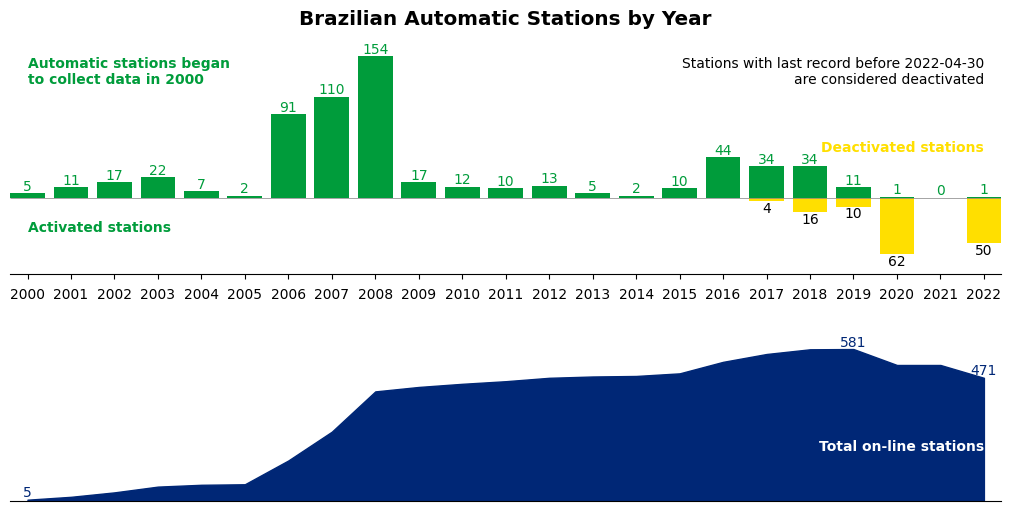

In [5]:
fig, ax = plt.subplots(
    nrows=2,
    figsize=(10, 5),
    dpi=100,
    gridspec_kw=dict(height_ratios=[1.25,1]),
    constrained_layout=True,
    sharex=True
)

# Stations Activated by Year
p00 = ax[0].bar(x=stations_sum['Year'], height=stations_sum['Activated stations'], color='#009c3b')
p0 = ax[0].bar_label(p00, label_type='edge', color='#009c3b')

p0 = ax[0].annotate(f'Automatic stations began\nto collect data in {stations_sum.Year.min()}',
                    xy=(stations_sum['Year'].min(), stations_sum['Activated stations'].max()),
                    verticalalignment="top",
                    horizontalalignment='left',
                    color='#009c3b',
                    fontweight="bold")

p0 = ax[0].annotate('Activated stations',
                    xy=(stations_sum['Year'].min(), -25),
                    verticalalignment="top",
                    horizontalalignment='left',
                    color='#009c3b',
                    fontweight="bold")

p01 = ax[0].bar(x=stations_sum['Year'],
                height=-stations_sum['Deactivated stations'],
                color='#ffdf00')

p0 = ax[0].bar_label(p01, label_type='edge', labels=stations_sum['Deactivated stations label'], color='black')

p0 = ax[0].annotate('Deactivated stations',
                    xy=(stations_sum['Year'].max(), stations_sum['Deactivated stations'].max()),
                    verticalalignment="top",
                    horizontalalignment='right',
                    color='#ffdf00',
                    fontweight="bold")

p0 = ax[0].annotate('Stations with last record before {}\nare considered deactivated'.format(stations.record_last.max().strftime('%Y-%m-%d')),
                    xy=(stations_sum['Year'].max(), stations_sum['Activated stations'].max()),
                    verticalalignment="top",
                    horizontalalignment='right',
                    color='black')


p0 = ax[0].margins(0,0.1)

xmin, xmax = ax[0].get_xlim()
p0 = ax[0].hlines(y=0, xmin=xmin, xmax=xmax, colors='grey', linewidths=0.5)

p0 = ax[0].grid(visible=False)
p0 = ax[0].yaxis.set_visible(False)
p0 = ax[0].spines[['right', 'left', 'top']].set_visible(False)

p0 = ax[0].set_xticks(stations_sum['Year'])

# Stations on-line by year
p1 = ax[1].stackplot(stations_sum['Year'], stations_sum['On-line stations'], color='#002776')

p1 = ax[1].annotate(y0, xy=(x0, y0), horizontalalignment="center", verticalalignment="bottom", color='#002776')
p1 = ax[1].annotate(y1, xy=(x1, y1), horizontalalignment="center", verticalalignment="bottom", color='#002776')
p1 = ax[1].annotate(y2, xy=(x2, y2), horizontalalignment="center", verticalalignment="bottom", color='#002776')

p1 = ax[1].annotate('Total on-line stations',
                    xy=(stations_sum['Year'].max(), stations_sum.iloc[-1]['On-line stations'] / 2),
                    verticalalignment="top",
                    horizontalalignment='right',
                    color='white',
                    fontweight="bold")

p1 = ax[1].margins(0,0.25)

p1 = ax[1].set_xticks(stations_sum['Year'])

p1 = ax[1].tick_params(labelbottom=False,labeltop=True) 

p1 = ax[1].grid(visible=False)
p1 = ax[1].yaxis.set_visible(False)
p1 = ax[1].spines[['right', 'left', 'top']].set_visible(False)

p1 = ax[1].tick_params(labelbottom=False, bottom=False)

plt.suptitle('Brazilian Automatic Stations by Year', fontsize='x-large', fontweight="bold")

plt.show()

In [6]:
stations_sum.iloc[-1]['On-line stations']

471

# 3. Weather Change at Brazilian Cities

As I said before, I am seeking to create a notebook that compares climate change between two cities in Brazil that has an automatic weather station. In the first notebook, I collected the data from the INMET website and I did one first summarize step. On this first step, we picked the hourly data and aggregate it into on day period base. On of the next steps that will be done on this notebook will be make another tranformation step to monthly based.

Returning to the dataset, the next table presets the columns on the database and the transformations that we will aplly:

In [7]:
# Creating the table with information
df_vars = pd.DataFrame(
    data={
        'Portuguese': ['ESTACAO', 'DATA', 'HORA', 'PRECIPITACAO TOTAL HORARIO',
                       'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA',
                       'PRESSAO ATMOSFERICA MAX.NA HORA ANT.',
                       'PRESSAO ATMOSFERICA MIN. NA HORA ANT.', 'RADIACAO GLOBAL',
                       'TEMPERATURA DO AR - BULBO SECO, HORARIA','TEMPERATURA DO PONTO DE ORVALHO',
                       'TEMPERATURA MAXIMA NA HORA ANT.', 'TEMPERATURA MINIMA NA HORA ANT.',
                       'TEMPERATURA ORVALHO MAX. NA HORA ANT.', 'TEMPERATURA ORVALHO MIN. NA HORA ANT.',
                       'UMIDADE REL. MAX. NA HORA ANT.', 'UMIDADE REL. MIN. NA HORA ANT.',
                       'UMIDADE RELATIVA DO AR, HORARIA', 'VENTO, DIRECAO HORARIA',
                       'VENTO, RAJADA MAXIMA', 'VENTO, VELOCIDADE HORARIA'],
        'English': ['STATION', 'DATE', 'TIME', 'TOTAL HOURLY RAIN',
                    'ATMOSPHERIC PRESSURE AT STATION LEVEL, TIME',
                    'MAX. ATMOSPHERIC PRESSURE IN THE PREVIOUS TIME.',
                    'ATMOSPHERIC PRESSURE MIN. IN THE EARLY TIME.', 'GLOBAL RADIATION',
                    'AIR TEMPERATURE - DRY BULB, TIME', 'DEW POINT TEMPERATURE',
                    'MAXIMUM TEMPERATURE IN THE PREVIOUS TIME.', 'MINIMUM TEMPERATURE IN THE PREVIOUS TIME.',
                    'MAX DEW TEMPERATURE. IN THE EARLY TIME.', 'DEW TEMPERATURE MIN. IN THE EARLY TIME.',
                    'REL HUMIDITY MAX. IN THE EARLY TIME.', 'REL HUMIDITY MIN IN THE EARLY TIME.',
                    'RELATIVE AIR HUMIDITY, HOURS', 'WIND, TIME DIRECTION', 'WIND, MAXIMUM GUNS',
                    'WIND, HOUR SPEED'],
        'Measure' : [' ', 'YYYY-MM-DD',
                     'UTC', 'mm', 'mB',
                     'mB', 'mB', 'W/m²',
                     'ºC', 'ºC', 'ºC',
                     'ºC', 'ºC', 'ºC',
                     '%', '%', '%',
                     'gr', 'm/s', 'm/s'],
        'Select' : ['', '', '', 'Yes', '', '', '', 'Yes', 'Yes', '', 'Yes', 'Yes', '', '', 'Yes', 'Yes', 'Yes', '', 'Yes', 'Yes'],
        'Aggreation' : ['', '', '', 'Maximun', '', '', '',
                        'Maximun', 'Average', '', 'Maximun', 'Minimun',
                        '', '', 'Maximun', 'Minimun', 'Average', '',
                        'Maximun', 'Average'],
        'Column Name' : ['', '', '', 'rain_max', '', '', '',
                         'rad_max', 'temp_avg', '', 'temp_max',
                         'temp_min', '', '', 'hum_max', 'hum_min',
                         'hum_avg', '', 'wind_max', 'wind_avg', ]
    }
)

# Showing
HTML(df_vars.to_html(escape=False,index=False, justify='center'))

Portuguese,English,Measure,Select,Aggreation,Column Name
ESTACAO,STATION,,,,
DATA,DATE,YYYY-MM-DD,,,
HORA,TIME,UTC,,,
PRECIPITACAO TOTAL HORARIO,TOTAL HOURLY RAIN,mm,Yes,Maximun,rain_max
"PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA","ATMOSPHERIC PRESSURE AT STATION LEVEL, TIME",mB,,,
PRESSAO ATMOSFERICA MAX.NA HORA ANT.,MAX. ATMOSPHERIC PRESSURE IN THE PREVIOUS TIME.,mB,,,
PRESSAO ATMOSFERICA MIN. NA HORA ANT.,ATMOSPHERIC PRESSURE MIN. IN THE EARLY TIME.,mB,,,
RADIACAO GLOBAL,GLOBAL RADIATION,W/m²,Yes,Maximun,rad_max
"TEMPERATURA DO AR - BULBO SECO, HORARIA","AIR TEMPERATURE - DRY BULB, TIME",ºC,Yes,Average,temp_avg
TEMPERATURA DO PONTO DE ORVALHO,DEW POINT TEMPERATURE,ºC,,,


Here I get an important point, we will only compare cities on the period that automatic stations are working as well in both cities. As default our notebook will compare **Juiz de Fora, Minas Gerais**, my actual home city, with **Brasilia**, Brazilian capital. Other important thing is, we will only compare the variable on the period that the two stations present data. On other words, we will look to first and last record of each station and analyze our observations.

OBS.: cities selections are hard code. The first version used Juiz de Fora and Divinopolis. On next version, I will try to choose randomly the cities.

OBS.: on the statistical analysis section we will need more than 30 months to compare. On this way, we will drop stations with less than 42 months (12 months as reference plus 30 months to compare).


In [8]:
# Filtering stations with less than 42 months operating
stations['station_filter'] = (stations['record_last'] - stations['record_first']) > pd.to_timedelta(42 * 30, unit='d')

In [9]:
# Evaluating the timedelta criteria
# Start condition
_timedelta = True

while _timedelta:
    # Selecting the cities
    id_stations_sample = stations.sample(n=2)
    
    # Updating condition
    _timedelta = (id_stations_sample['record_last'].min() - id_stations_sample['record_first'].max()) < pd.to_timedelta(42 * 30, unit='d')

# This lines are use to hard code the stations
id_station_1 = 'A518' # id_stations_sample.iloc[0]['id_station'] # 'A518' 

id_station_2 = 'A001' # id_stations_sample.iloc[1]['id_station'] # 'A001' 

stations_city = stations[stations['id_station'].isin([id_station_1, id_station_2])].reset_index(drop=True)

### 3.1. Graphical Analysis

Given the cities, let's see how far they are and how long our analysis will be!

In [10]:
# Visualizing both cities on a map
# Function to calculate distance bewteen the two cities
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # Convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # Haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return int(round(c * r, 0))

# Writing the plot title
lon1, lat1 = stations_city.loc[0][['lon', 'lat']]

lon2, lat2 = stations_city.loc[1][['lon', 'lat']]

dist_cities = haversine(lon1, lat1, lon2, lat2)

plot_title = stations_city.loc[0]['city_station'] + ' and ' + stations_city.loc[1]['city_station'] + \
    ' are ' + str(dist_cities) + 'km apart...'

# Hoverdata
hover_map = {
    'state':True,
    'id_station':True,
    'lon':':.4f',
    'lat':':.4f',
}

fig = px.scatter_geo(stations_city,
                    lat='lat',
                    lon='lon',
                    symbol='station_on',
                    color='year_last_str',
                    hover_name='city_station',
                    hover_data=hover_map,
                    # fitbounds="locations",
                    title=plot_title,
                    labels={
                        'year_last_str':'Last Record Year',
                        'station_on':'Station Online',
                        'state':'State',
                        'id_station':'ID',
                        'lat':'Lat',
                        'lon':'Lon'
                    },
                    scope='south america',
                    width=750,
                    )

fig.show()

In [11]:
# Importing weather information
weather = pd.read_csv(
    '../input/brazil-weather-information-by-inmet/weather_sum_all/weather_sum_all.csv',
    parse_dates=['DATA (YYYY-MM-DD)']
)

# Renaming columns
weather.columns.values[0] = 'id_station'
weather.columns.values[1] = 'date'

# Filtering by stations
weather = weather[weather['id_station'].isin(stations_city['id_station'])].reset_index(drop=True)

# Filtering by period of analysis
date_start = stations_city['record_first'].max()
date_end = stations_city['record_last'].min()

# Filtering the weather information by records at sametime
weather = weather[
    (weather['date'] >= date_start) & (weather['date'] <= date_end)
].reset_index(drop=True)

# Filling implicit
data_range = pd.date_range(start=date_start, end=date_end)

index = pd.MultiIndex.from_product(
    [weather['id_station'].unique(), data_range],
    names=['id_station','date'])

weather = weather.set_index(['id_station','date']).reindex(index).reset_index()

# Filtering the weather information by cities chosen
weather_cities = weather.merge(stations_city, on='id_station')

# Finding and preseting the period of analysis
period = str(weather_cities['record_first'].max().strftime('%Y-%m-%d')) + ' to ' + str(weather_cities['record_last'].max().strftime('%Y-%m-%d'))

# This will be use on last plots
period_years = weather_cities['year_last'].max() - weather_cities['year_first'].max()

display(Markdown('Our analysis will cover the **' + period + '**. Lets see some plots!'))

Our analysis will cover the **2007-05-26 to 2022-04-30**. Lets see some plots!

In [12]:
# Cleaning and preparing for integrid analysis
cols_sum = list(weather.columns.values[2:])

cols_fix = ['city_station', 'state']

for col in weather.columns:
    cols_fix.append(col)

_cols_drop = [col for col in weather_cities.columns if col not in cols_fix]
    
weather_cities.drop(columns=_cols_drop, inplace=True, errors='ignore')

# Reference for the first year
day_ref = weather_cities['date'].min() + timedelta(days=365)

# Finding year, month and day
weather_cities['record_year'] = pd.DatetimeIndex(weather_cities['date']).year
weather_cities['record_month'] = pd.DatetimeIndex(weather_cities['date']).month
weather_cities['record_day'] = pd.DatetimeIndex(weather_cities['date']).day

# Removing the leap day
weather_cities_day = weather_cities[~((weather_cities['record_month'] == 2) & (weather_cities['record_day'] == 29))]

There is a important thing that we need to be assured: we can not have a full month on the 12 first months with missing values. Let's begin understand how many month per column are completely with missing values!

In [13]:
# Analyzing the data integrid
cols_group = ['state', 'city_station', 'record_year', 'record_month']

weather_cities_month_integrity = weather_cities_day.groupby(cols_group)[cols_sum].agg(lambda x: x.isna().mean())

weather_cities_month_integrity = weather_cities_month_integrity == 1

cols_name = {
    'state' : 'State',
    'city_station' : 'Station',
    'rain_max':  'Maximun Hour Rain',
    'rad_max':  'Maximun Radiation',
    'temp_avg':  'Average Temperature',
    'temp_max':  'Maximun Temperature',
    'temp_min':  'Minimun Temperature',
    'hum_max':  'Maximun Humidit',
    'hum_min':  'Minimun Humidit',
    'wind_max':  'Maximun Wind Speed',
    'wind_avg':  'Average Wind Speed',
    'temp_delta': 'Maximun Delta Temperature',
    'hum_delta': 'Maximun Delta Humity'
}

def show_df_integrity(df: pd.DataFrame,title: str):
    """"Function to present the dataframe integrity analysis.
    """
    df = df.reset_index().groupby(['state','city_station'])[cols_sum].sum()

    df = df.reset_index().rename(columns=cols_name)

    return HTML('<strong>' + title + '</strong><br>' + df.to_html(escape=False,index=False, justify='center'))

show_df_integrity(weather_cities_month_integrity,'Months with all missing values per station')

State,Station,Maximun Hour Rain,Maximun Radiation,Average Temperature,Maximun Temperature,Minimun Temperature,Maximun Humidit,Minimun Humidit,Maximun Wind Speed,Average Wind Speed
DF,BRASILIA,0,0,0,0,0,0,0,0,0
MG,JUIZ DE FORA,0,0,0,0,0,0,0,0,0


Let's see the first 12 months now!

In [14]:
weather_cities_month_integrity['ref_month'] = weather_cities_month_integrity.groupby(['state', 'city_station']).cumcount()

weather_cities_month_integrid_1y = weather_cities_month_integrity[weather_cities_month_integrity['ref_month'] < 12]

show_df_integrity(weather_cities_month_integrid_1y,'Months with all missing values per station on the first year')

State,Station,Maximun Hour Rain,Maximun Radiation,Average Temperature,Maximun Temperature,Minimun Temperature,Maximun Humidit,Minimun Humidit,Maximun Wind Speed,Average Wind Speed
DF,BRASILIA,0,0,0,0,0,0,0,0,0
MG,JUIZ DE FORA,0,0,0,0,0,0,0,0,0


In [15]:
if weather_cities_month_integrid_1y[cols_sum].sum().sum() == 0:
    print('Any column present a complete month with missing values on the 12 first months.\n\nLets continue our analysis!')
else:
    raise Exception('One or more columns present a complete month with missing values on the 12 first months.\n\nLets stop here!')

Any column present a complete month with missing values on the 12 first months.

Lets continue our analysis!


Now that we analysed our data integrity, let's play with our data to create some plots! For each variable will be present a panel with the first year as the referece and the the most upper and lower value. Beyonde this, we will present the ratio between the reference the extreme values. And, we made some filtering on our data to better visualization.

In [16]:
# Slicing data into ref (first year) and rec (remaining)
weather_cities_day_ref = weather_cities_day[weather_cities['date'] < day_ref]

weather_cities_day_rec = weather_cities_day[~(weather_cities['date'] < day_ref)]

# Dealing with columns that wont be reshaped
cols_days = ['state', 'id_station', 'city_station', 'record_year', 'record_month', 'record_day']

cols_id = [col for col in weather_cities_day_ref.columns if col not in cols_sum]

# Reshaping ref data
weather_cities_day_ref_melt = weather_cities_day_ref.melt(
    id_vars=cols_id,
    var_name='weather_var',
    value_name='weather_value'
)

# Creating a reference for day
weather_cities_day_ref_melt['ref_day'] = weather_cities_day_ref_melt.groupby(['id_station', 'weather_var']).cumcount().add(1) % 365 

weather_cities_day_ref_melt.loc[weather_cities_day_ref_melt['ref_day'] == 0, 'ref_day'] = 365

# Creating a reference for year
weather_cities_day_ref_melt['ref_year'] = weather_cities_day_ref_melt.groupby(['id_station', 'weather_var']).cumcount().add(1) // 365

# Reshaping rec data
weather_cities_day_rec_melt = weather_cities_day_rec.melt(
    id_vars=cols_id,
    var_name='weather_var',
    value_name='weather_value'
)

# Merging ref and rec data
weather_cities_day_compare = weather_cities_day_ref_melt.merge(
    weather_cities_day_rec_melt,
    on=['state', 'id_station', 'city_station', 'record_month', 'record_day', 'weather_var'],
    suffixes=('_ref', '_rec')
)

In [17]:
# Dealing with missing values
weather_cities_day_compare.sort_values(['id_station', 'city_station', 'weather_var', 'ref_day'], inplace=True)

weather_cities_day_compare.set_index(['id_station', 'city_station', 'weather_var', 'ref_day'], inplace=True)

# weather_cities_day_compare['weather_value_ref'].interpolate(limit_direction='both', inplace=True)

weather_cities_day_compare.reset_index(inplace=True)

weather_cities_day_compare = weather_cities_day_compare.fillna(method="ffill")

# Finding the upper and lower information per day
_cols = ['state', 'city_station', 'id_station', 'ref_day', 'weather_var', 'weather_value_ref', 'weather_value_rec']

weather_cities_day_compare = weather_cities_day_compare.sort_values(_cols)

_cols = ['state', 'id_station', 'city_station', 'ref_day', 'weather_var']

weather_cities_day_compare = weather_cities_day_compare.groupby(_cols, as_index=False).nth([0, -1])

weather_cities_day_compare['position'] = weather_cities_day_compare.groupby(_cols, as_index=False).cumcount()

weather_cities_day_compare['position'].replace(({0: 'Lower', 1: 'Upper'}), inplace=True)

# Calculating the log proportion by the first year
weather_cities_day_compare['var_kpi'] = np.log(
    weather_cities_day_compare['weather_value_rec'] / weather_cities_day_compare['weather_value_ref']
)

weather_cities_day_compare['var_weather'] = weather_cities_day_compare['weather_value_rec'] / weather_cities_day_compare['weather_value_ref']

# Filtering violantion on lower and upper conditions
_condition_lower = (weather_cities_day_compare['position'] == 'Lower') & (weather_cities_day_compare['var_kpi'] > 0)

_condition_upper = (weather_cities_day_compare['position'] == 'Upper') & (weather_cities_day_compare['var_kpi'] < 0)

weather_cities_day_compare = weather_cities_day_compare[~_condition_lower & ~_condition_upper]

In [18]:
# Slicing and listing data frame to plot
def weather_slice(df=weather_cities_day_compare):
    return [
        df[df['city_station'] == df['city_station'].unique()[0]],
        df[df['city_station'] == df['city_station'].unique()[1]]
    ]

weather_plot_day = weather_slice()

# Dictionaries to help label the plots
cols_name = {
    'rain_max':  'Maximun Hour Rain',
    'rad_max':  'Maximun Radiation',
    'temp_avg':  'Average Temperature',
    'temp_max':  'Maximun Temperature',
    'temp_min':  'Minimun Temperature',
    'hum_max':  'Maximun Humidit',
    'hum_min':  'Minimun Humidit',
    'wind_max':  'Maximun Wind Speed',
    'wind_avg':  'Average Wind Speed',
    'temp_delta': 'Maximun Delta Temperature',
    'hum_delta': 'Maximun Delta Humity'
}

cols_name_y = {
    'rain_max':  'Hour Rain (mm)',
    'rad_max':  'Radiation (W/m2)',
    'temp_avg':  'Average Temperature (oC)',
    'temp_max':  'Maximun Temperature (oC)',
    'temp_min':  'Minimun Temperature (oC)',
    'hum_max':  'Maximun Humidit (%)',
    'hum_min':  'Minimun Humidit (%)',
    'hum_avg':  'Average Humidit (%)',
    'wind_max':  'Wind Speed (m/s)',
    'wind_avg':  'Wind Speed (m/s)',
    'temp_delta': 'Maximun Delta Temperature (oC)',
    'hum_delta': 'Maximun Delta Humity (%)'
}

dict_month = {
    1: 'Jan',
    2: 'Fev',
    3: 'Mar',
    4: 'Abr',
    5: 'May',
    6: 'Jun',
    7: 'Jul',
    8: 'Ago',
    9: 'Set',
    10: 'Oct',
    11: 'Nov',
    12: 'Dec'
}

# Defining the xticks
_first_day = weather_cities_day_compare.loc[weather_cities_day_compare['record_day'] == 1, 'ref_day'].min()

xticksmarks = [_first_day + 30*m for m in range(12)]

xtickslabels = weather_cities_day_compare[weather_cities_day_compare['record_day'] == 1]['record_month'].unique()

xtickslabels = [dict_month[x] for x in xtickslabels]

# Color palette
colors = ["#FF0B04", "#4374B3"]

# Counting the number of 
def rel_log_plot(weather_var='temp_max',city=0):
    
    if city == 0:
        city_2 = 1
    else:
        city_2 = 0
    
    df_0 = weather_plot_day[city][(weather_plot_day[city]['weather_var'] == weather_var)]
    df_2 = weather_plot_day[city_2][(weather_plot_day[city_2]['weather_var'] == weather_var)]
    
    g = sns.lineplot(
        x="ref_day",
        y='var_weather',
        hue='position',
        hue_order=['Lower', 'Upper'],
        palette=sns.color_palette(colors),
        ci=None,
        data=df_0,
        ax=ax[0, city]
    )

    g = sns.lineplot(
        x="ref_day",
        y='var_weather',
        hue='position',
        hue_order=['Lower', 'Upper'],
        palette=sns.color_palette(colors),
        ci=None,
        alpha=0.75,
        legend=False,
        data=df_2,
        ax=ax[0, city]
    )

    ax[0, city].get_legend().set_title('')
    
    ax[0, city].set_ylabel('Ratio Weather Var')
    
    ax[0, city].margins(0,0)
    
    xmin, xmax = ax[0, city].get_xlim()
    p0 = ax[0, city].hlines(y=1, xmin=xmin, xmax=xmax, colors='grey', linewidths=0.5)

    g.set_xlabel('')
    
    g.set_ylim(bottom=0, top=2)
    
    g.set_xticks(xticksmarks, labels=xtickslabels)
    
    g.set_title(
        weather_plot_day[city]['state'].unique()[0] + ' - ' + weather_plot_day[city]['city_station'].unique()[0],
        fontsize='x-large')
    
    return g

# Line plot considering the weather_var by day on the fist year
def line_plot_day(weather_var='temp_max',city=0):
    
    df = weather_plot_day[city][(weather_plot_day[city]['weather_var'] == weather_var)]
    
    # Dealing with outliers
    lim_lower = df['weather_value_ref'].mean() - 1 * df['weather_value_ref'].std()

    lim_upper = df['weather_value_ref'].mean() + 1 * df['weather_value_ref'].std()

    df.loc[(df['weather_value_ref'] < lim_lower), 'weather_value_ref'] = np.NaN

    df.loc[(df['weather_value_ref'] > lim_upper), 'weather_value_ref'] = np.NaN 
    
    g = sns.lineplot(
        x="ref_day",
        y='weather_value_ref',
        color='grey',
        ci=None,
        data=df,
        ax=ax[1, city],
        label='First Year'
    )

    g = sns.scatterplot(
        x="ref_day",
        y='weather_value_rec',
        hue='position',
        hue_order=['Lower', 'Upper'],
        palette=sns.color_palette(colors),
        s=9,
        data=df,
        ax=ax[1, city]
    )    

    g.set_xticks(xticksmarks, labels=xtickslabels)
    
    xlabel = 'Line = Values on ' + str(date_start.strftime('%Y-%m-%d')) + ' to ' + str(date_end.strftime('%Y-%m-%d')) + ' | Points = Following Years'
        
    g.set_xlabel(xlabel)
    
    g.set_ylabel(cols_name_y[weather_var])
    
    g.set_ylim(auto=True)
    g.set_ylim(bottom=0)
    
    ax[1, city].get_legend().set_title('')
    ax[1, city].margins(0,0)
    
    ax[1, city].tick_params(labelbottom=False, labeltop=True, bottom=False, top=True)
    
    return g

The next plots goals is cath if weather if change by day of year. But, before we see the plots, it is important to say that I am improving data viz of these plots. The actual version is a little bit junkie. I like the general ideas, but I need to apply more time on them. Perhaps, on next version, I will redesigner these panels to achieve better insight.

The first row of each panel shows a plot to compare the upper and lower weather variable per day. The line transparent is the other city. In this way, closer lines means climate change more equal and on next version I will shade this region between lines. I applied a line on y-axis to better vizualization. Other important things, values closer than 1 means less climate change

The second row of each panel shows the first year and the upper and lower value for that day on following years.

Speaking specificly about Maximun Hour Rain, I manually removed this variable. Considering that many days does not rain, the plots were the definition of nightmare to me!

#### 3.1.1. Maximun Humidit

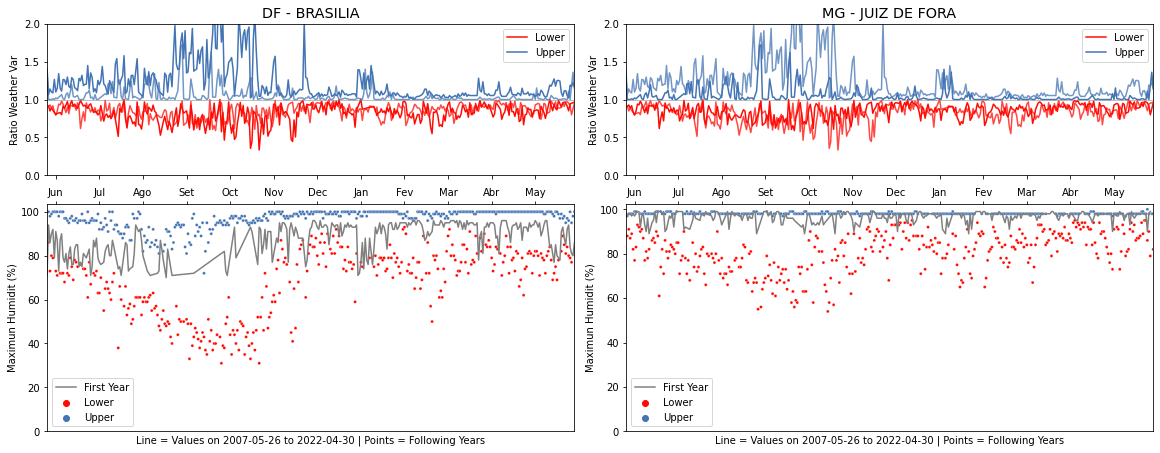

#### 3.1.2. Minimun Humidit

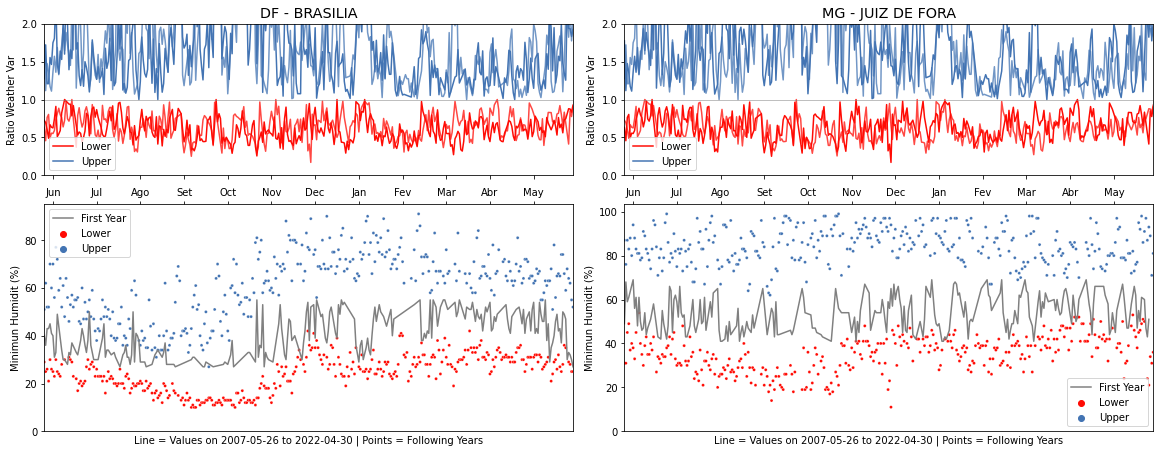

#### 3.1.3. Maximun Radiation

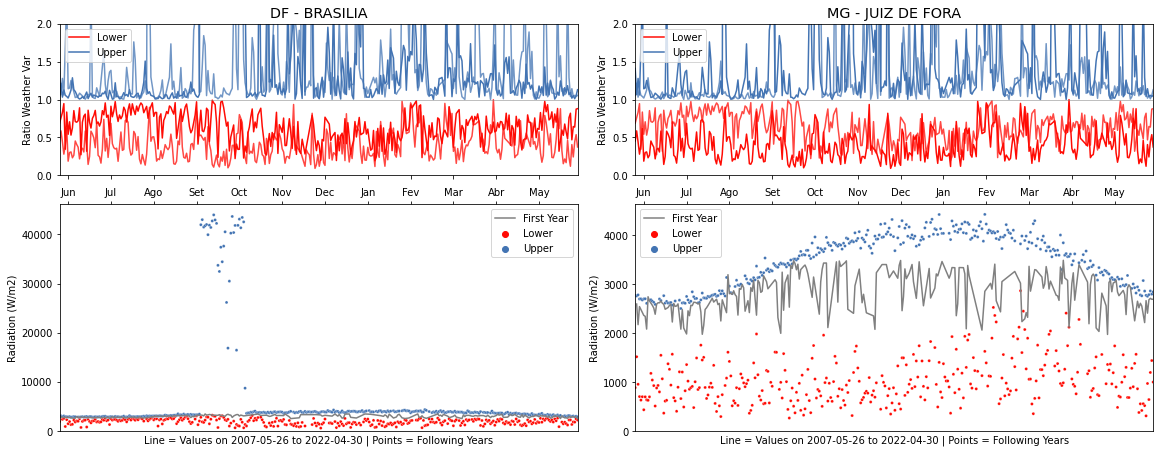

#### 3.1.4. Average Temperature

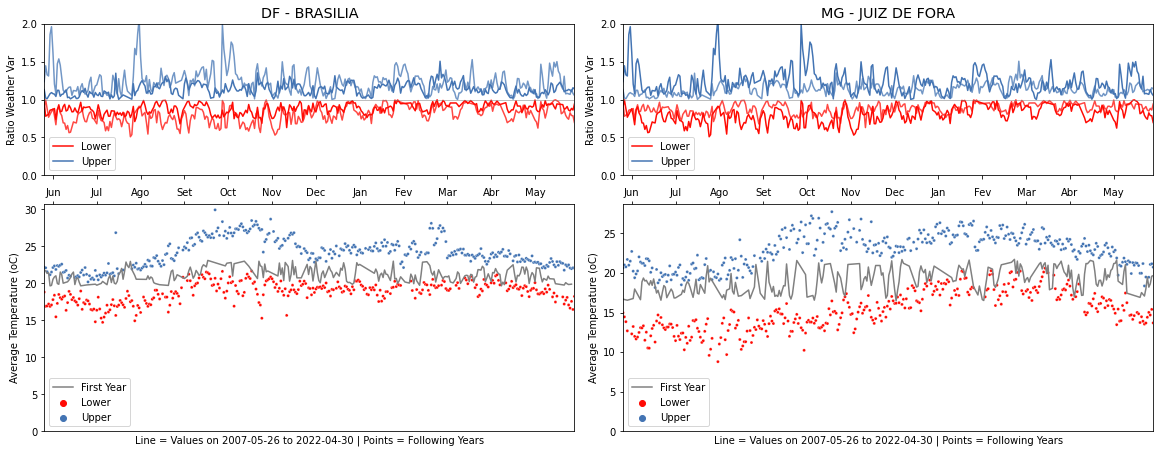

#### 3.1.5. Maximun Temperature

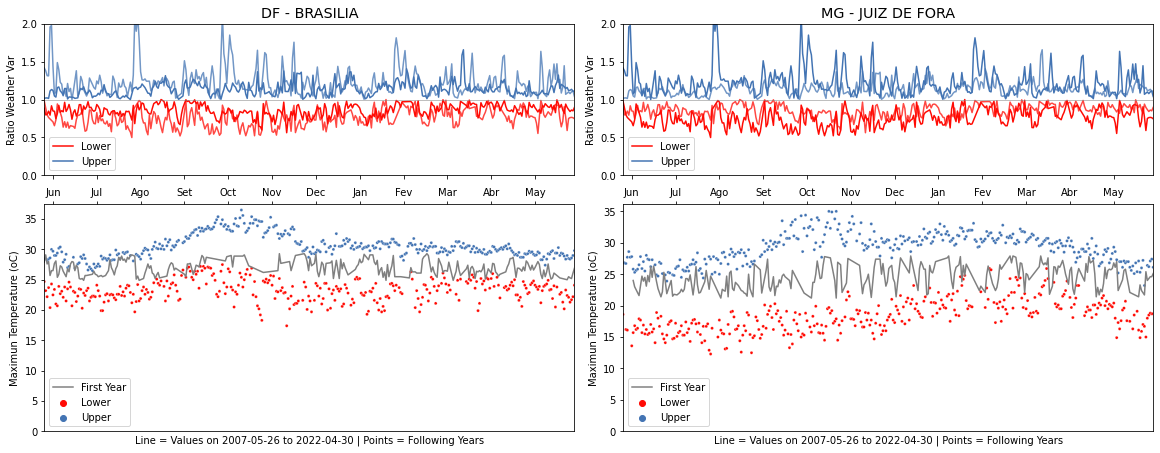

#### 3.1.6. Minimun Temperature

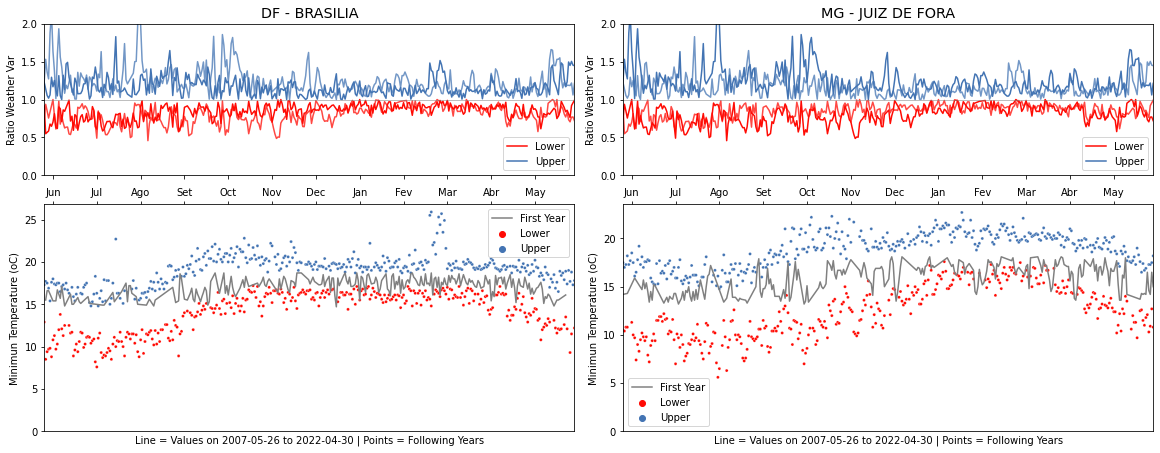

#### 3.1.7. Average Wind Speed

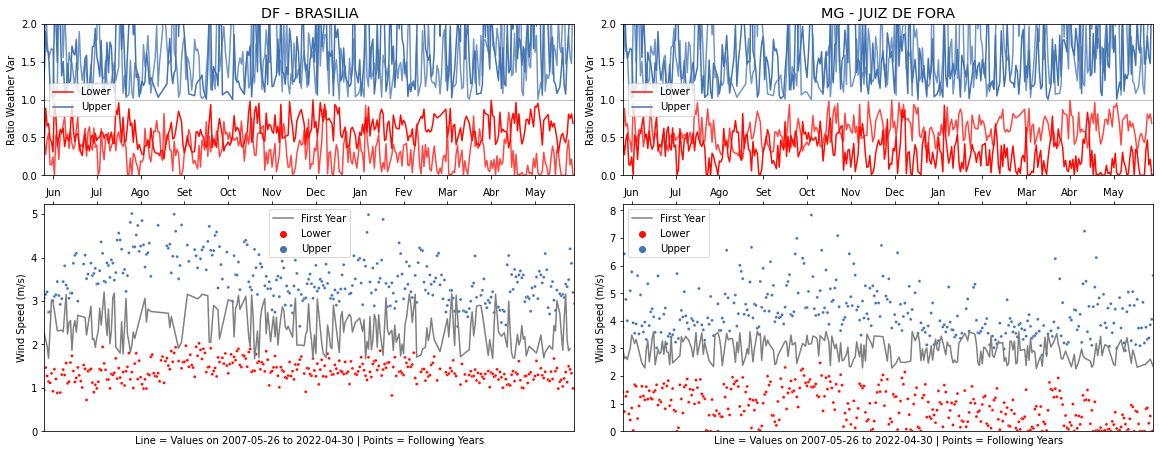

#### 3.1.8. Maximun Wind Speed

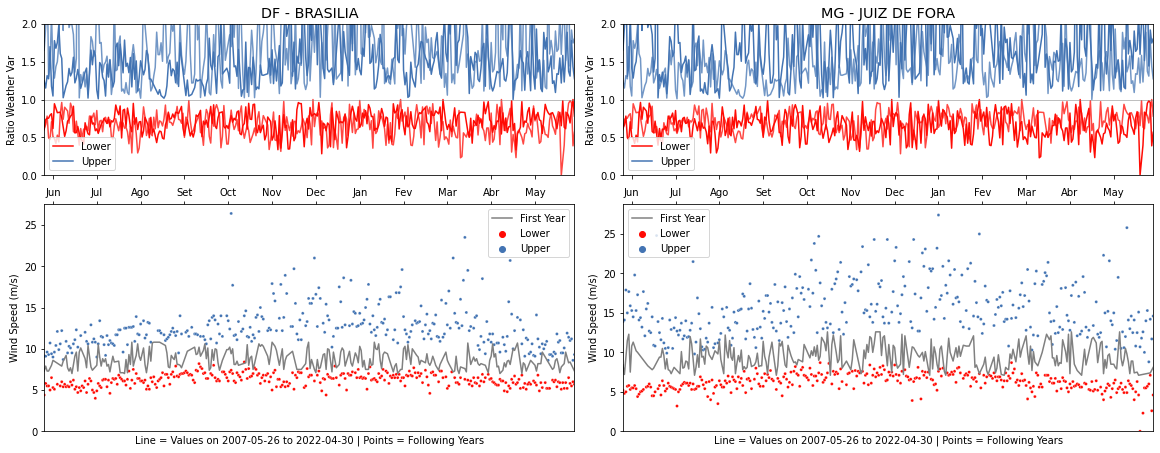

In [19]:
# Creating a list of tuples to iterate over
weather_var = weather_plot_day[0]['weather_var'].unique()

# Removing the rain_max variable manually
weather_var = [col for col in weather_var if col != 'rain_max']

for i, var in enumerate(weather_var):
    
    display(Markdown('#### 3.1.' + str(i+1) + ". " + cols_name[var]))
    
    f, ax = plt.subplots(
        2, 2,
        figsize=(16, 10 * 0.618),
        gridspec_kw=dict(width_ratios=[3, 3], height_ratios=[1, 1.5]),
        constrained_layout=True,
        sharex=True)

    g1 = rel_log_plot(weather_var=var, city=0)

    g2 = rel_log_plot(weather_var=var, city=1)
    
    g3 = line_plot_day(weather_var=var, city=0)

    g4 = line_plot_day(weather_var=var, city=1)
    
    plt.show()

Well, these are pretty plots! But, the process to reach some insights is a little bit on the user, plot by plot. Let's find statistical way to analyze the climate change between the cities.

### 3.2. Hypothesis Test

Climate change is real. There is a lot of studies done about it and we do not want to prove it or measure how strong it is. Well, but we can see if our two cities present the same changes on the study period. To reach this, we will define the reference with the 12 first month and them compare month by month with the rest of period. Here, we may read compare as:

$$\frac {month\_act}{month\_ref}$$

Now, it is time to define our hypothesis:

- H<sub>0</sub>: the weather change equally between cities, considering the measures analyzed.

- H<sub>A</sub>: the weather change diferently between cities, considering the measures analyzed.

To acomplish this we will apply two t-test:

1. between the all variables together; and,

2. between each variable at one time and them a correction with Holm’s method. OBS.: I tried to use the [pingouin.pairwise_tests](https://pingouin-stats.org/generated/pingouin.pairwise_tests.html#pingouin.pairwise_tests) function, but I got many errors. I will try to understand this later. For now, I calculated each p-value and then corrected them.

On preparation to write this notebook, I used the following resources:

- [DataCamp Course: Hypothesis Testing in Python](https://app.datacamp.com/learn/courses/hypothesis-testing-in-python) by [James Chapman ](https://www.linkedin.com/in/jameschapman5/);

- [Article: How to Compare Two or More Distributions](https://towardsdatascience.com/how-to-compare-two-or-more-distributions-9b06ee4d30bf) by [Matteo Courthoud](https://www.linkedin.com/in/matteo-courthoud/)

- [Article: Statistical hypothesis testing, types of errors, and interpretation of p values](https://www.reneshbedre.com/blog/hypothesis-testing.html) by [Renesh Bedre](https://www.linkedin.com/in/reneshbedre/).

- [Book: OpenIntro Statistics](https://www.openintro.org/book/os/)

- [Pingouin Package Documentation](https://pingouin-stats.org/index.html)

The t-test assumptions, as [Bedre summarized](https://www.reneshbedre.com/blog/ttest.html), are:

1. Observations in two groups have an approximately normal distribution (Shapiro-Wilks Test).
2. Homogeneity of variances (variances are equal between treatment groups) (Levene or Bartlett Test).
3. The two groups are sampled independently from each other from the same population.

Starting by the 3rd assumption, we may say our rows are independent each other and by the two groups. For the 1st and 2nd assumptions, let's create some plots to see them. However, first let's do some data transformation to prepare our data!

In [20]:
# Summaring cities data
# Creating the agg dictionary
cols_agg = {}
for col in cols_sum:
    if col[-3] == 'm':
        cols_agg[col] = col[-3:]
    else:
        cols_agg[col] = 'mean'
        
weather_cities_sum = weather_cities.groupby(['id_station', 'state', 'city_station', 'record_year', 'record_month'], as_index=False).agg(cols_agg)

# Creating a fake indexing as reference
month_station_1 = sum(weather_cities_sum['id_station'] == id_station_1)
month_station_2 = sum(weather_cities_sum['id_station'] == id_station_2)

if month_station_1 == month_station_2:
    print("The cities show the same number of months.")
else:
    raise Exception('The cities does not show the same number of months.\n\nLets stop here!')

The cities show the same number of months.


In [21]:
weather_cities_sum['month_agg'] = weather_cities_sum.groupby('id_station').cumcount().add(1)

weather_cities_sum['month_ref'] = weather_cities_sum['month_agg'] % 12

weather_cities_sum.loc[weather_cities_sum['month_ref'] == 0, 'month_ref'] = 12

cols_id = [col for col in weather_cities_sum.columns if col not in cols_sum]

weather_cities_sum_melt = weather_cities_sum.melt(
    id_vars=cols_id,
    var_name='weather_var',
    value_name='weather_val'
)

weather_cities_ref = weather_cities_sum_melt.groupby(['id_station', 'weather_var']).head(12)

# Important: insert a protection for one ref equal 0
if ((weather_cities_ref['weather_val'] == 0).sum() == 0):
    print('Nothing to worrie zero values!')
else:
    weather_cities_ref.loc[(weather_cities_ref['weather_val'] == 0)] = np.NaN
    weather_cities_ref = weather_cities_ref.fillna(method="ffill")
    print('Well, there were some zeros on the ref column. We fill them with NaN and then with the previous value.')

Well, there were some zeros on the ref column. We fill them with NaN and then with the previous value.


In [22]:
# Important: insert a protection for a month only with NA
if (weather_cities_ref['weather_val'].isna().sum() == 0):
    print('Nothing to worrie about NA values!')
else:
    weather_cities_ref = weather_cities_ref.fillna(method="ffill")
    print('Well, there were some null values on the ref column! We filled then with the previous value.')

Nothing to worrie about NA values!


In [23]:
weather_cities_compare = weather_cities_sum_melt.loc[weather_cities_sum_melt['month_agg'] > 12].merge(
    weather_cities_ref, 
    on=['id_station', 'state', 'city_station', 'month_ref', 'weather_var'],
    suffixes=('_act', '_ref')
)

weather_cities_compare['weather_val_kpi'] = weather_cities_compare['weather_val_act'] / weather_cities_compare['weather_val_ref']

month_na = weather_cities_compare.loc[weather_cities_compare['weather_val_act'].isna(), ['weather_var', 'month_agg_act']]

left_joined = weather_cities_compare.merge(
    month_na,
    how='left', 
    on=['weather_var', 'month_agg_act'],
    indicator=True)

weather_cities_compare_clean = left_joined.loc[left_joined['_merge'] == 'left_only']

weather_cities_compare_clean.drop(columns=['_merge'], inplace=True)

Our next step is our plots. However, before it, let's define our threshold for p-value into 0.05. On this way:

- if p-value > 0.05, we fail to reject the null hypothesis; but,

- if p-value < 0.05, we will accept our alternative hypothesis!

Let's being our t-tests!

In [24]:
# p-value treshold
alpha = 0.05

def weather_compare_df(weather_var=None):
    """This function will create slice into
    the weather_cities_compare_clean dataframe
    to calculate p-value and create some plots.
    """
    if weather_var == None:
        df = weather_cities_compare_clean
    else:
        df = weather_cities_compare_clean.loc[weather_cities_compare_clean['weather_var'] == weather_var]
    return df

def ttest_weather(weather_var=None):
    """This function will calculate the p-value
    between the two cities on our dataframe.
    """
    df = weather_compare_df(weather_var)
    
    x = df.loc[
        df['city_station'] == df['city_station'].unique()[0],
        'weather_val_kpi']

    y = df.loc[
        df['city_station'] == df['city_station'].unique()[1],
        'weather_val_kpi']

    ttest_df = pg.ttest(x, y, paired=True).reset_index()
    
    ttest_df = ttest_df.round(4)
    
    if weather_var == None:
        ttest_df['weather_var'] = 'all_vars'
    else:
        ttest_df['weather_var'] = weather_var
    
    return ttest_df

In [25]:
# Starting a df to stor the p-values
p_values_df = ttest_weather(weather_var=None)

# Calculating each p-value
for col in cols_sum:
    
    df = ttest_weather(weather_var=col)
    
    p_values_df = pd.concat([p_values_df, df], ignore_index=True)
    
# Droping columns
p_values_df = p_values_df.loc[:,['weather_var', 'p-val']]

# Calculating the correction 
reject, pvals_corr = pg.multicomp(p_values_df.loc[1: ,'p-val'], method='holm')

# Filling the dataframe with corrections
p_values_df.loc[1:, 'p-val-corr'] = pvals_corr
p_values_df.loc[1:, 't-test_result'] = reject

p_values_df.iloc[0,-1] = p_values_df.iloc[0, 1] < alpha

# Preparing results
rows_name = {
    'rain_max':  'Maximun Hour Rain',
    'rad_max':  'Maximun Radiation',
    'temp_avg':  'Average Temperature',
    'temp_max':  'Maximun Temperature',
    'temp_min':  'Minimun Temperature',
    'hum_max':  'Maximun Humidit',
    'hum_min':  'Minimun Humidit',
    'wind_max':  'Maximun Wind Speed',
    'wind_avg':  'Average Wind Speed',
    'temp_delta': 'Maximun Delta Temperature',
    'hum_delta': 'Maximun Delta Humity',
    'all_var': 'All Variables'
}

cols_name = {
    'weather_var': 'Variable',
    't-test_result': 't-test result'
}

p_value_print = p_values_df.rename(columns=cols_name)

p_value_print['Variable'] = p_value_print['Variable'].map(rows_name)

if p_values_df.iloc[0,-1]:
    ttest_label = 'fail to reject null hypothesis'
else: 
    ttest_label = 'accept null hypothesis'
    
title = 'Hypothesis result: ' + ttest_label
subtitle = 'After the correction, {:,.2%} of variables are different between the cities.'.format(p_values_df.iloc[1:,-1].mean())

HTML('<strong>' + title + '.</strong><br>' +
     subtitle + '<br>' + p_value_print.to_html(escape=False,index=False, justify='center'))

Variable,p-val,p-val-corr,t-test result
NaN,0.0002,NaN,True
Maximun Hour Rain,0.0001,0.0005,True
Maximun Radiation,0.1178,0.3534,False
Average Temperature,0.0007,0.0028,True
Maximun Temperature,0.8633,0.8633,False
Minimun Temperature,0.0000,0.0000,True
Maximun Humidit,0.0000,0.0000,True
Minimun Humidit,0.0000,0.0000,True
Maximun Wind Speed,0.2530,0.5060,False
Average Wind Speed,0.0000,0.0000,True


Now, let's see some plots to confirm our calculations!

In [26]:
brazilian_colors = ['#009c3b', '#ffdf00']

def dist_comp_plot(weather_var=None):
    """"This fucntion create a panel with density, cumulative density and QQ plot.
    This function works to whole data or just for one weather measure.
    """
    
    df = weather_compare_df(weather_var)
    
    f, ax = plt.subplots(
        nrows=1, ncols=3,
        figsize=(12, 3),
        dpi=90,
        gridspec_kw=dict(width_ratios=[1,1,1]),
        constrained_layout=True)

    # Density Histogram
    sns.histplot(
        data=df,
        x="weather_val_kpi",
        hue="city_station",
        palette=sns.color_palette(brazilian_colors),
        fill=False,
        common_norm=False,
        element='step',
        ax=ax[0])

    ax[0].set_title('Density histogram')
    ax[0].get_legend().set_title('Cities')
    ax[0].set_xlabel('Weather Comparation')
    
    # Ajusting x limits to better vizualization
    x0, x1 = ax[0].get_xbound()
    
    x0 = max(0, x0)
    x1 = min(5, x1)
    
    ax[0].set_xlim(x0, x1)
    
    # Cumulative distribution function
    sns.histplot(
        data=df,
        x="weather_val_kpi",
        hue="city_station",
        palette=sns.color_palette(brazilian_colors),
        fill=False,
        common_norm=False,
        cumulative=True,
        element='step',
        ax=ax[1])

    ax[1].set_title('Cumulative distribution function')
    ax[1].get_legend().set_title('Cities')
    ax[1].set_xlabel('Weather Comparation')
    
    # Ajusting x limits to better vizualization
    x0, x1 = ax[1].get_xbound()
    
    x0 = max(0, x0)
    x1 = min(5, x1)
    
    ax[1].set_xlim(x0, x1)

    # QQ Plot
    kpis = df['weather_val_kpi'].values
    kpis_0 = df.loc[df['city_station'] == df['city_station'].unique()[0], 'weather_val_kpi'].values
    kpis_1 = df.loc[df['city_station'] != df['city_station'].unique()[0], 'weather_val_kpi'].values

    kpis_pct = pd.DataFrame()
    kpis_pct[df['city_station'].unique()[0]] = np.percentile(kpis_0, range(100))
    kpis_pct[df['city_station'].unique()[1]] = np.percentile(kpis_1, range(100))

    plt.scatter(x=df['city_station'].unique()[0], y=df['city_station'].unique()[1], data=kpis_pct, label='Actual fit');

    axes = plt.gca()
   
    x0, x1 = np.array(axes.get_xlim())
    y0, y1 = np.array(axes.get_ylim())
    
    x_vals = np.array([min(x0, y0), min(x1, y1)])
    
    plt.plot(x_vals, x_vals, '--', c='red', label='Line of perfect fit')

    plt.xlabel(df['city_station'].unique()[0])

    plt.ylabel(df['city_station'].unique()[1])

    plt.legend()
    
    axes.axis('equal')

    plt.title("QQ plot")
    
    ax[2].set_xlim(x_vals)
    ax[2].set_ylim(x_vals)
    
    # Creating the title
    suptitleplot = 'Distribution Analysis'
    
    # Picking the variable name
    if weather_var != None:
        suptitleplot = suptitleplot + ' - ' + cols_name_y[weather_var]
    else:
        suptitleplot = suptitleplot + ' - ' + 'Whole Variables'
    
    # Picking the results
    if weather_var == None:
        ttest_res, ttest_val = p_values_df.iloc[0,-1], p_values_df.iloc[0,1]
    else:
        ttest_res = p_values_df.loc[p_values_df['weather_var'] == weather_var, 't-test_result'].values[0]
        ttest_val = p_values_df.loc[p_values_df['weather_var'] == weather_var, 'p-val-corr'].values[0]
    
    # Analysing the result
    if ttest_res:
        ttest_label = 'Fail to reject null hypothesis'
    else: 
        ttest_label = 'Accept null hypothesis'
    
    plt.suptitle(suptitleplot + '\np-value = ' + '{:.4f}'.format(ttest_val) + ' | ' + ttest_label)
    
    plt.show()

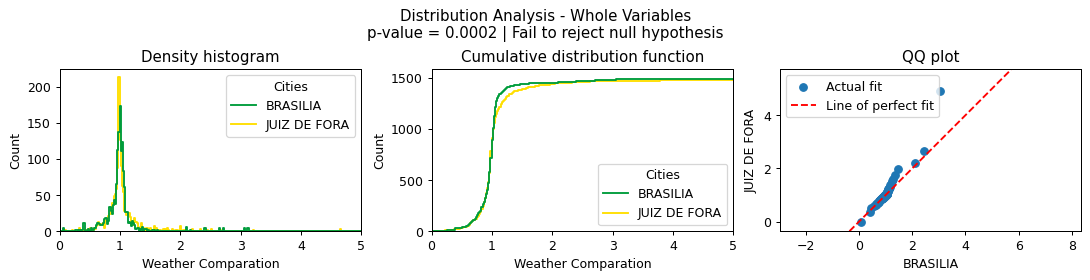

In [27]:
dist_comp_plot(weather_var=None)

Now that we analysis the whole data, let's dig into each weather variable.

#### 3.2.1. Maximun Hour Rain<br>

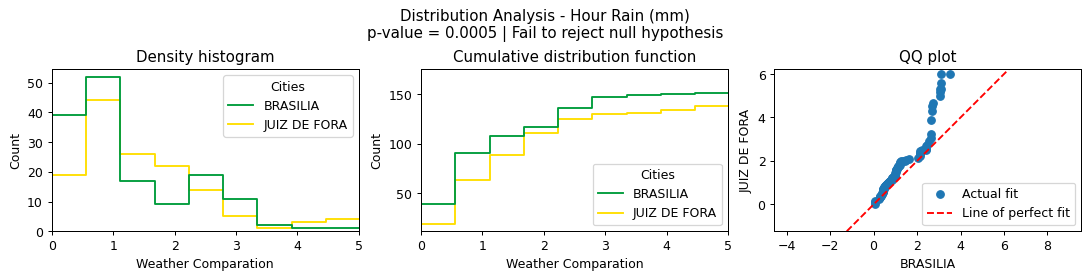

#### 3.2.2. Maximun Radiation<br>

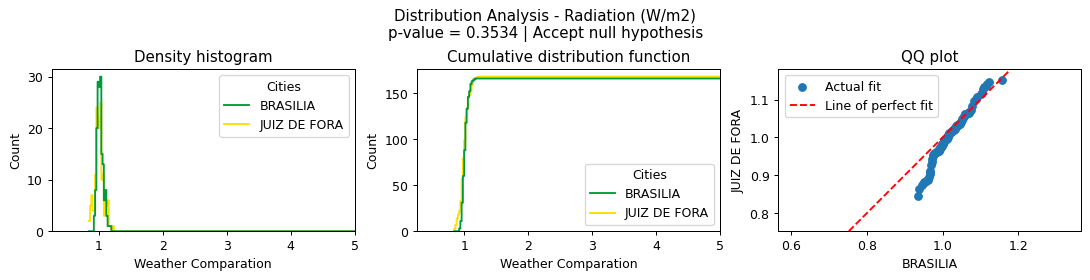

#### 3.2.3. Average Temperature<br>

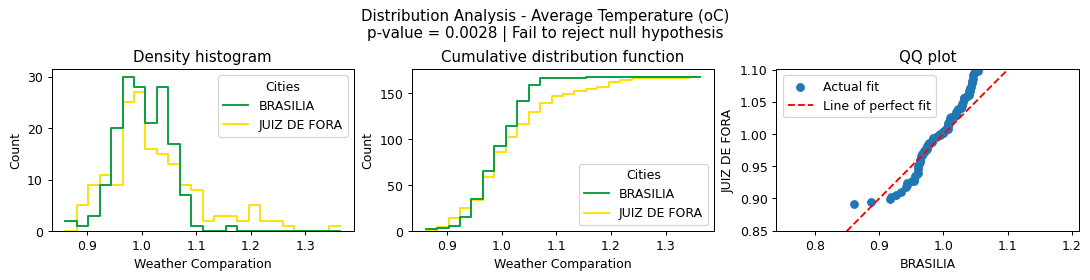

#### 3.2.4. Maximun Temperature<br>

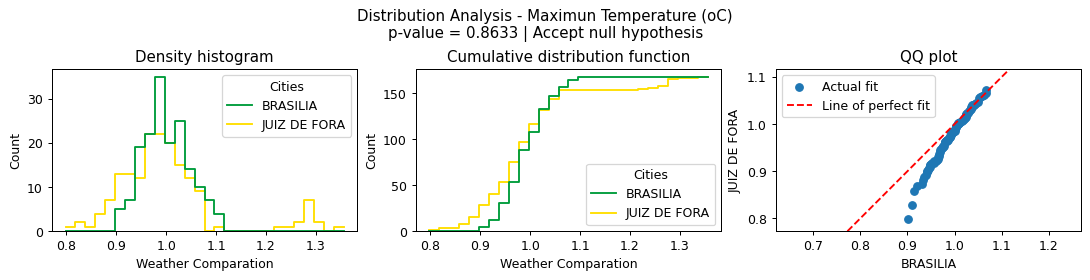

#### 3.2.5. Minimun Temperature<br>

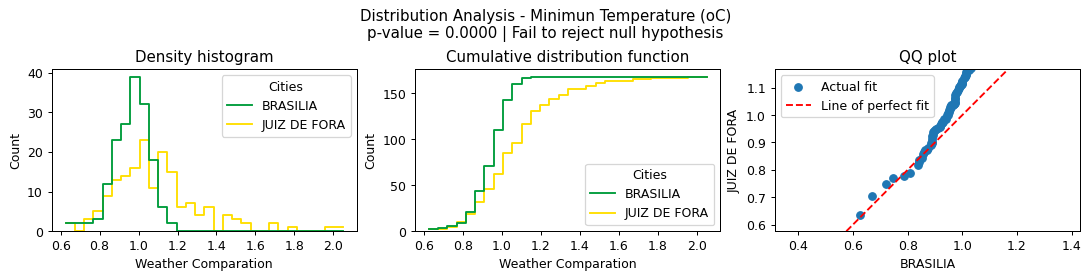

#### 3.2.6. Maximun Humidit<br>

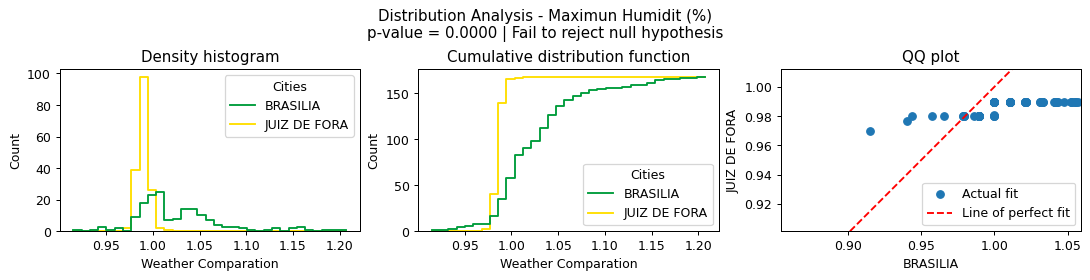

#### 3.2.7. Minimun Humidit<br>

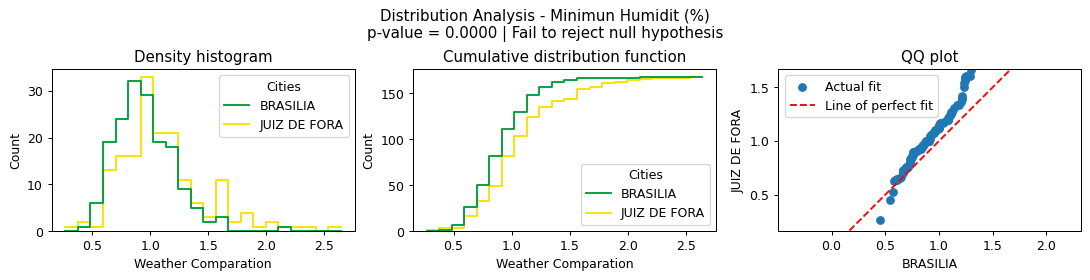

#### 3.2.8. Maximun Wind Speed<br>

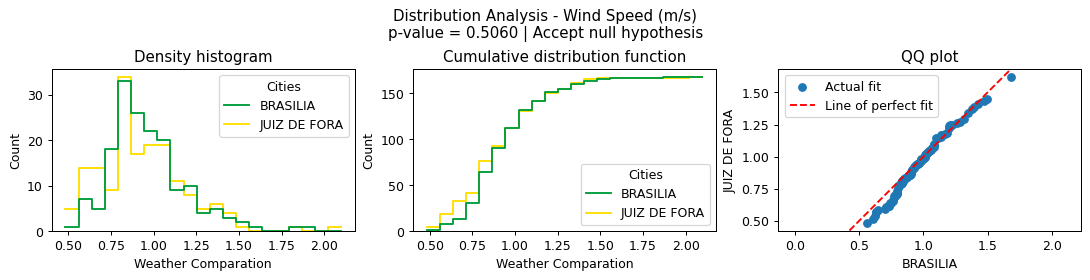

#### 3.2.9. Average Wind Speed<br>

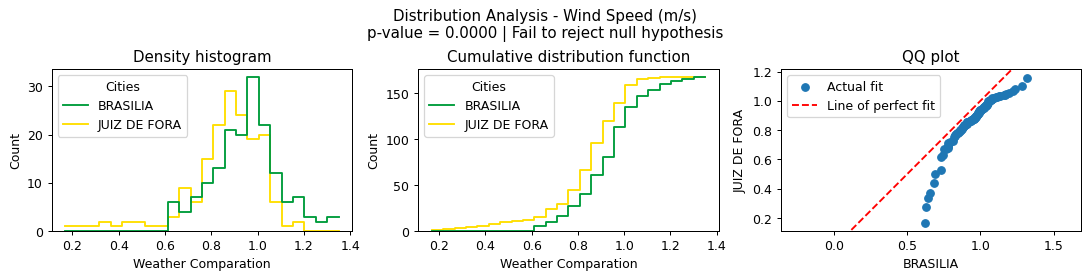

In [28]:
# Creating a list of tuples to iterate over
weather_var = weather_cities_compare_clean['weather_var'].unique()

for i, var in enumerate(weather_var):
    
    display(Markdown('#### 3.2.' + str(i+1) + '. ' + rows_name[var] + '<br>'))
    
    dist_comp_plot(weather_var=var)

The plot confirm our calculations! There are more things that I want to try with this data. For now, it is done! :-)